# Similarities thresholds for different N of time points / measurements
Higher number of dimensions leads to lower cosine similarity, due to more noise. Thus similarity thresholds must be chosen based on number of measurments per strain.

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
from IPython.display import display
from statistics import median, mean
from scipy.cluster.hierarchy import dendrogram
import pickle as pkl
import glob
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

from Orange.clustering.louvain import jaccard

import library_regulons
reload(library_regulons)
from library_regulons import *
import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle


In [2]:
dataPath = '/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'

In [4]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [11]:
# Group strains based on N measurments
SPLITBY = 'Strain'
size_dict = defaultdict(list)
merged = ClusterAnalyser.merge_genes_conditions(genes=genes, conditions=conditions[['Measurment', SPLITBY]],
                                                matching='Measurment')
splitted = ClusterAnalyser.split_data(data=merged, split_by=SPLITBY)
for rep, data in splitted.items():
    splitted[rep] = data.drop([SPLITBY, 'Measurment'], axis=1).T
    size_dict[data.shape[0]].append(rep)


Similarity threshold is here estimated based on distribution of similarities to the closest neighbour of each gene. The distribution is strongly shifted towards higher similarities, presumably because most expressed genes have at least one close neighbour (e.g. are part of some metabolic process where genes are co-regulated). Thus by selecting a threhold on the knee of the distribution it might be possible to find a threshold that correcponds to biological meaning of similarity. 

AX4
MybBGFP
acaA
mybB
pkaR
PkaCoe
amiB
cudA
dgcA
ac3PkaCoe
acaAPkaCoe
comH
ecmARm
gbfA
gtaC
tagB
tgrB1
tgrB1C1
tgrC1
gtaG
gtaI


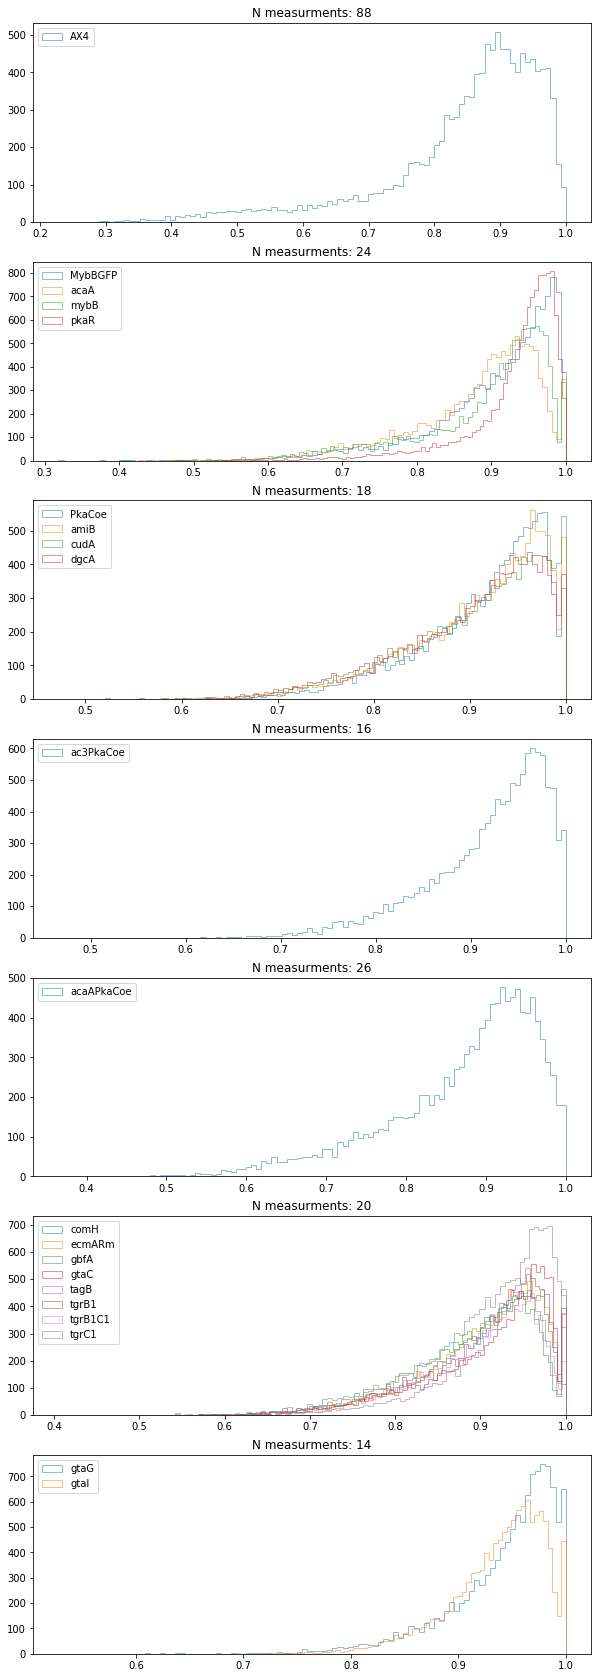

In [70]:
# Calculate similarities to the closest neighbour and plot them
LOG=True
NEIGHBOURS=2
SCALE='mean0std1'

sims_dict=dict()
fig, axs = plt.subplots(len(size_dict), 1,figsize=(10,30))
axN=-1
for size_group,strains in size_dict.items():
    axN+=1
    for strain in strains:
        data=splitted[strain]
        #print(strain)
        neighbour_calculator = NeighbourCalculator(genes=data)
        neigh, sims_dict[strain] = neighbour_calculator.neighbours(n_neighbours=NEIGHBOURS, inverse=False, scale=SCALE,
                                                            log=LOG, return_neigh_dist=True,remove_self=True)
        axs[axN].hist(sims_dict[strain].mean(axis=1), bins=100, histtype = 'step', fill = None, alpha=0.5,label=strain)
    axs[axN].legend(loc='upper left')
    axs[axN].set_title('N measurments: '+str(size_group)) 

However, despite same number of measurements, some strains differ in the profile and knee shape. This migh be due to diferent technical noise. If a single threshold is selected for all strains with same N of measurements the strains vary strongly in number of selected genes - all this variation may not be solely biological. Thus the thresholds could be selected for each strain separately.

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../orange3venv/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


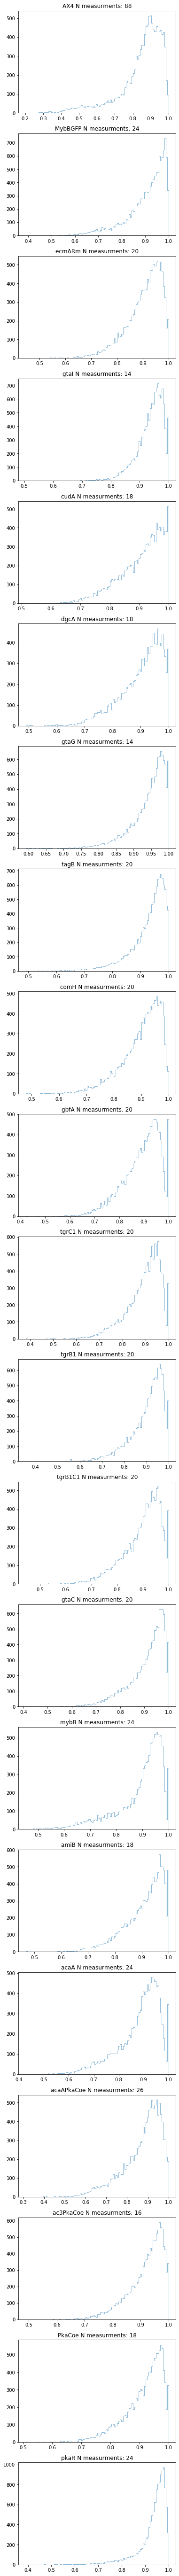

In [12]:
# Calculate similarities to the closest neighbour and plot them
LOG=True
NEIGHBOURS=2
SCALE='mean0std1'

sims_dict=dict()
strains=conditions['Strain'].unique()
fig, axs = plt.subplots(len(strains), 1,figsize=(6,100))
axN=-1
for strain in strains:
    axN+=1
    data=splitted[strain]
    #print(strain)
    neighbour_calculator = NeighbourCalculator(genes=data)
    neigh, sims_dict[strain] = neighbour_calculator.neighbours(n_neighbours=NEIGHBOURS, inverse=False, scale=SCALE,
                                                        log=LOG, return_neigh_dist=True,remove_self=True)
    axs[axN].hist(sims_dict[strain].mean(axis=1), bins=100, histtype = 'step', fill = None, alpha=0.5,label=strain)
    axs[axN].set_title(strain+' N measurments: '+str(data.shape[1])) 

Many strains do not have an evident knee to base the selection of threshold on. This could reduce the reliability of threshold selection.

### Select N calculated neighbours
Compare N of retained genes/pairs based on N of calculated neighbours when using different thresholds and strains.

In [ ]:
# Dict for selected thershold for N points
threshold_dict={14:0.93,16:0.91,18:0.90,20:0.90,24:0.89,26:0.86,88:0.81}
# How many genes and gene pairs are retained based on N calculated neighbours, 
# using different strains and thus thresholds
retained_stats=[]
for size_group,strains in size_dict.items():
    for strain in strains:
        #print(strain)
        data=splitted[strain]
        neighbour_calculator=NeighbourCalculator(genes=data)
        gene_names=random.sample(list(neighbour_calculator._genes.index),1000)
        n_points=data.shape[1]
        main_threshold=threshold_dict[n_points]
        for neighbours in [50,100,200,300,400]:
            pairs = neighbour_calculator.neighbours(n_neighbours=neighbours, inverse=False, scale=SCALE,
                                                                    log=LOG,return_neigh_dist=False, 
                                                    genes_query_names=gene_names)
            for threshold in [main_threshold-0.01,main_threshold,main_threshold+0.01]:
                retained= NeighbourCalculator.filter_similarities(results=pairs, similarity_threshold=threshold)
                n_genes = len(set(gene for pair in retained for gene in pair))
                retained_stats.append({'kNN':neighbours,'Min similaririty':threshold,'N pairs':len(retained),
                                       'N genes':n_genes,'N points':n_points,'Group':strain})
retained_stats=pd.DataFrame(retained_stats)   

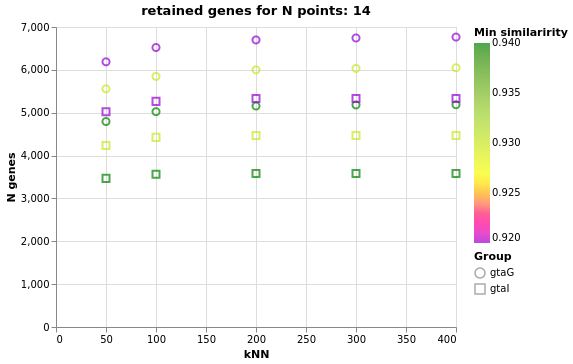

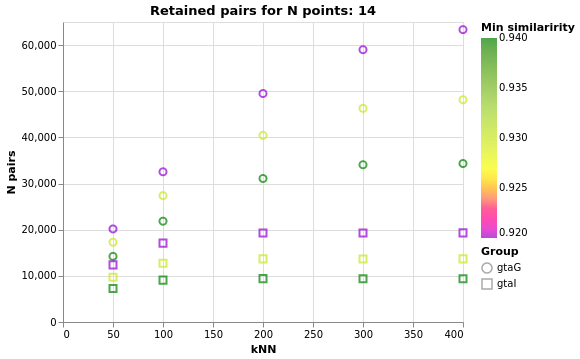

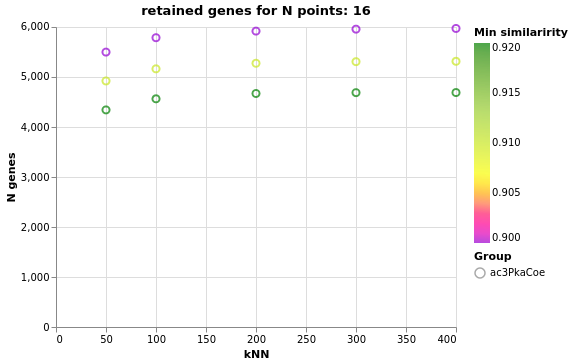

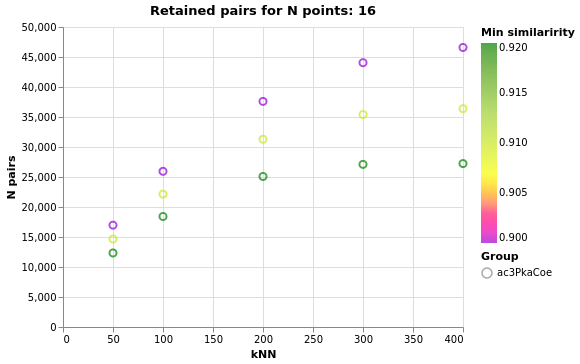

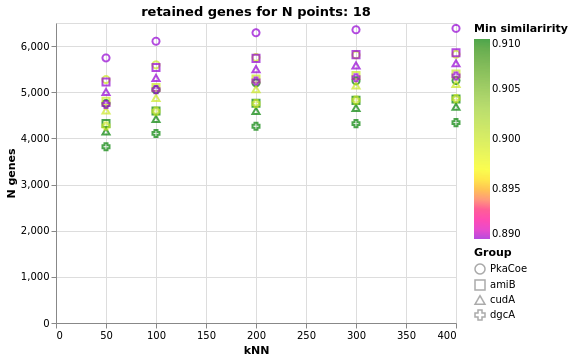

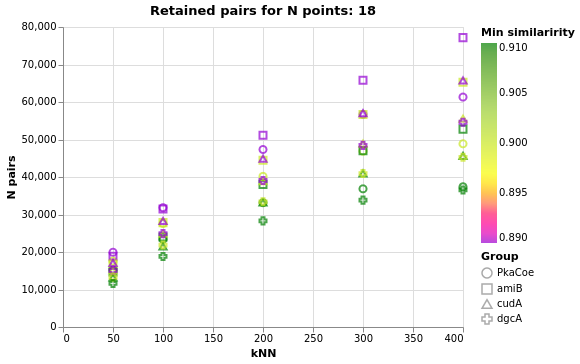

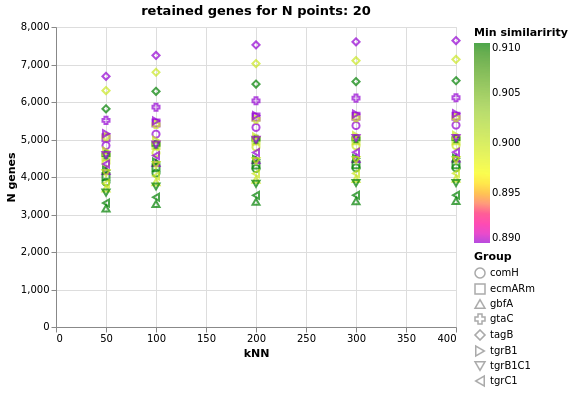

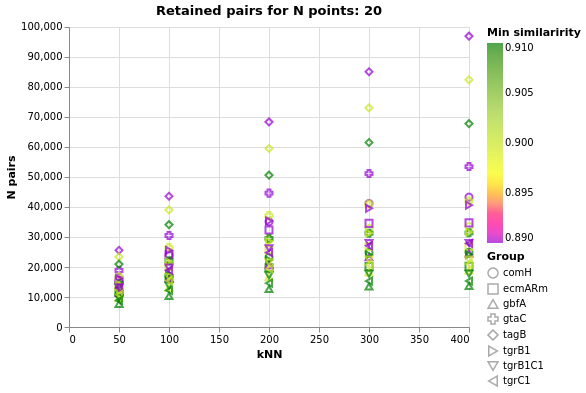

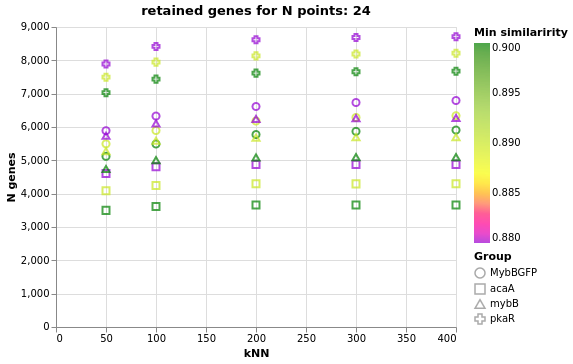

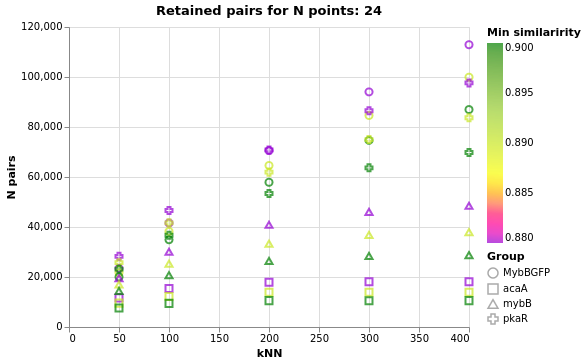

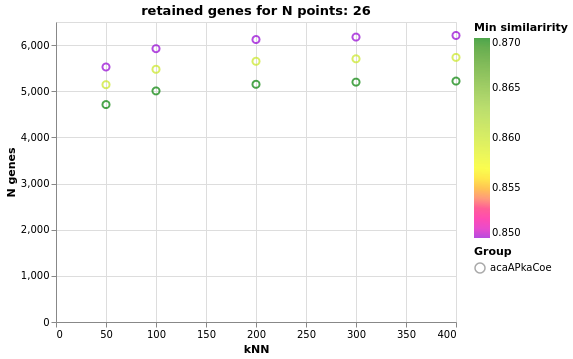

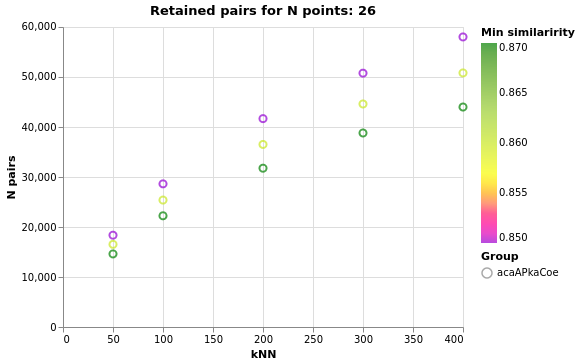

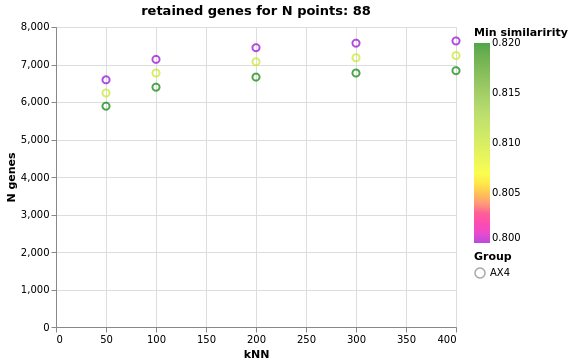

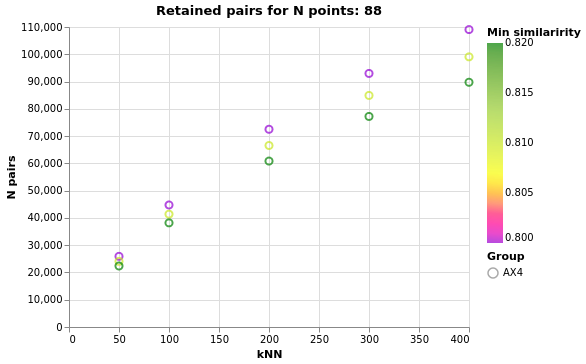

In [58]:
# Plot distn of retained genes and pairs based on N calculated neighbours 
# for each group of strains with N measurments
stats_groupped=retained_stats.groupby('N points')
for group in stats_groupped:
    chart=alt.Chart(pd.DataFrame(group[1])).mark_point().encode(x='kNN',y='N genes', shape='Group', 
                                   color=alt.Color('Min similaririty',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_point(size=50).properties(
        title='Retained genes for N points: '+str(group[0]))  
    display(chart)
    chart=alt.Chart(pd.DataFrame(group[1])).mark_point().encode(x='kNN',y='N pairs', shape='Group',
                                   color=alt.Color('Min similaririty',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_point(size=50).properties(
        title='Retained pairs for N points: '+str(group[0]))  
    display(chart)